## 1、定义算法

教程中提到相比于Q learning，DQN本质上是为了适应更为复杂的环境，并且经过不断的改良迭代，到了Nature DQN（即Volodymyr Mnih发表的Nature论文）这里才算是基本完善。DQN主要改动的点有三个：
* 使用深度神经网络替代原来的Q表：这个很容易理解原因
* 使用了经验回放（Replay Buffer）：这个好处有很多，一个是使用一堆历史数据去训练，比之前用一次就扔掉好多了，大大提高样本效率，另外一个是面试常提到的，减少样本之间的相关性，原则上获取经验跟学习阶段是分开的，原来时序的训练数据有可能是不稳定的，打乱之后再学习有助于提高训练的稳定性，跟深度学习中划分训练测试集时打乱样本是一个道理。
* 使用了两个网络：即策略网络和目标网络，每隔若干步才把每步更新的策略网络参数复制给目标网络，这样做也是为了训练的稳定，避免Q值的估计发散。想象一下，如果当前有个transition（这个Q learning中提过的，一定要记住！！！）样本导致对Q值进行了较差的过估计，如果接下来从经验回放中提取到的样本正好连续几个都这样的，很有可能导致Q值的发散（它的青春小鸟一去不回来了）。再打个比方，我们玩RPG或者闯关类游戏，有些人为了破纪录经常Save和Load，只要我出了错，我不满意我就加载之前的存档，假设不允许加载呢，就像DQN算法一样训练过程中会退不了，这时候是不是搞两个档，一个档每帧都存一下，另外一个档打了不错的结果再存，也就是若干个间隔再存一下，到最后用间隔若干步数再存的档一般都比每帧都存的档好些呢。当然你也可以再搞更多个档，也就是DQN增加多个目标网络，但是对于DQN则没有多大必要，多几个网络效果不见得会好很多。

### 1.1、定义模型

前面说了DQN的模型不再是Q表，而是一个深度神经网络，这里我只用了一个三层的全连接网络（FCN），这种网络也叫多层感知机（MLP），至于怎么用Torch写网络这里就不多说明了，以下仅供参考。

In [1]:
import torch.nn as nn
import torch.nn.functional as F
class MLP(nn.Module):
    def __init__(self, n_states,n_actions,hidden_dim=128):
        """ 初始化q网络，为全连接网络
        """
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(n_states, hidden_dim) # 输入层
        self.fc2 = nn.Linear(hidden_dim,hidden_dim) # 隐藏层
        self.fc3 = nn.Linear(hidden_dim, n_actions) # 输出层
        
    def forward(self, x):
        # 各层对应的激活函数
        x = F.relu(self.fc1(x)) 
        x = F.relu(self.fc2(x))
        return self.fc3(x)

### 1.2、定义经验回放

经验回放首先是具有一定容量的，只有存储一定的transition网络才会更新，否则就退回到了之前的逐步更新了。另外写经验回放的时候一般需要包涵两个功能或方法，一个是push，即将一个transition样本按顺序放到经验回放中，如果满了就把最开始放进去的样本挤掉，因此如果大家学过数据结构的话推荐用队列来写，虽然这里不是。另外一个是sample，很简单就是随机采样出一个或者若干个（具体多少就是batch_size了）样本供DQN网络更新。功能讲清楚了，大家可以按照自己的想法用代码来实现，参考如下。

In [2]:
from collections import deque
import random
class ReplayBuffer(object):
    def __init__(self, capacity: int) -> None:
        self.capacity = capacity
        self.buffer = deque(maxlen=self.capacity)
    def push(self,transitions):
        ''' 存储transition到经验回放中
        '''
        self.buffer.append(transitions)
    def sample(self, batch_size: int, sequential: bool = False):
        if batch_size > len(self.buffer): # 如果批量大小大于经验回放的容量，则取经验回放的容量
            batch_size = len(self.buffer)
        if sequential: # 顺序采样
            rand = random.randint(0, len(self.buffer) - batch_size)
            batch = [self.buffer[i] for i in range(rand, rand + batch_size)]
            return zip(*batch)
        else: # 随机采样
            batch = random.sample(self.buffer, batch_size)
            return zip(*batch)
    def clear(self):
        ''' 清空经验回放
        '''
        self.buffer.clear()
    def __len__(self):
        ''' 返回当前存储的量
        '''
        return len(self.buffer)

### 1.3、真定义算法

到了高级一点的算法，定义算法就比较麻烦，要先定义一些子模块，再定义好子模块之后我们就可以实现我们的算法核心部分。如下，可以看到，其实去掉子模块的话，DQN跟Q learning的算法结构没啥区别，当然因为神经网络一般需要Torch或者Tensorflow来写，因此推荐大家先去学一学这些工具，比如"eat_pytorch_in_20_days"。

这里我们主要分析一下DQN的更新过程，也就是update函数。首先我们知道目前所有基于深度神经网络的更新方式都是梯度下降，如下：
$$
\theta_i \leftarrow \theta_i - \lambda \nabla_{\theta_{i}} L_{i}\left(\theta_{i}\right)
$$
那么这个$\theta$又是什么呢，注意到前面我们讲的DQN跟Q learning算法的一个主要区别就是使用神经网络替代了Q表，而这个$\theta$实际上就是神经网络的参数，通常用$Q\left(s_{i}, a_{i} ; \theta\right)$表示。根据强化学习的原理我们需要优化的是对应状态下不同动作的长期价值，然后每次选择价值最大对应的动作就能完成一条最优策略，使用神经网络表示Q表时也是如此，我们将输入的状态数作为神经网络的输入层，动作数作为输出层，这样的神经网络表达的功能就跟在Q learning中的Q表是一样的，只不过具有更强的鲁棒性。

讲完了为什么要优化的是这个参数$\theta$，接下来我们从代码层面进一步剖析，稍微了解一点Torch知识的同学都知道，上面的公式其实只需要定义一个优化器，然后计算损失之后用优化器迭代即可，如下：
```python
optimizer = optim.Adam(Q_net.parameters(), lr=0.01) # 定义优化器，对应的网络是Q_net，学习率为0.01
loss = ... # 计算损失，这里掠过
# 然后优化器先zero_grad()，loss再反向传播，然后优化器step() ，这是一个固定的套路
optimizer.zero_grad()  
loss.backward()
optimizer.step() 
```
当然强烈建议同学们了解一下深度学习中的梯度下降，并且使用numpy实现，这样就会更加清楚整个梯度下降过程到底是怎么回事，上述只是在同学们了解了梯度下降的具体实现方式的前提下为了方便学习更多其他的知识形成的套路。这就好比我们玩一个竞技游戏，如果我们之前从来没有接触过该类游戏，那么肯定是从普通攻击，每个技能一步一步地学起打好基础，然后再学习技能连招等等也就是形成固定的套路，但是如果不先打基础，直接学习套路可能会是一脸懵逼的状态，尤其是很多高端玩家会对这些连招套路简化名称比如光速qa和1233321等等，一开始我们是很难听懂的。等当我们先打好基础，然后再学习了很多套路之后会发现这些基础并不能用得上，甚至有的时候可能会忽然忘记了这些基础，但其实我们并没有忘记，再回顾一遍也能很快拣起来。在这点上我想强调的是基础固然重要，但是不要死磕基础，除非是学术研究需要。再比如我们小学学完简单加减乘除之后很快就去背九九乘法表，而不会去过多纠结一加一等于几的问题，上大学后也是如此，只是很多时候我们很可能看起来这个问题值得研究，但意识不到自己就是在纠结一加一等于几的问题，这也是我在和众多读者们学习讨论的过程中在他们身上发现的问题。

回归正题，细心的同学会发现数学公式和代码的对应是有一定的壁垒的，只要通过多加练习跨越了这个壁垒，那么对于往后我们想要复现论文也会轻松许多。我们目前讲了参数的更新过程，但是最关键的是损失是如何计算的，在DQN中损失的计算相对来说比较简单，如下：
$$
L(\theta)=\left(y_{i}-Q\left(s_{i}, a_{i} ; \theta\right)\right)^{2}
$$
这里的$y_{i}$通常称为期望值，$Q\left(s_{i}, a_{i} ; \theta\right)$称为实际值，这个损失在深度学习中通常称作均方差损失，也就是mseloss，使用这个损失函数通常追溯到数学上的最小二乘法，感兴趣的同学可以了解一下深度学习中的各种损失函数以及各自的使用场景。
$y_{i}$在DQN中一般表示如下：
$$
y_{i}= \begin{cases}r_{i} & \text {对于终止状态} s_{i+1} \\ r_{i}+\gamma \max _{a^{\prime}} Q\left(s_{i+1}, a^{\prime} ; \theta\right) & \text {对于非终止状态} s_{i+1}\end{cases}
$$
该公式的意思就是将下一个状态对应的最大Q值作为实际值（因为实际值通常不能直接求得，只能近似），这种做法实际上只是一种近似，可能会导致过估计等问题，也有一些改善的方法具体可以在后面各种改进的DQN算法比如Double DQN中看到，在这里我们暂时不要深究为什么要用这个来近似实际值。然后注意到这里其实有一个终止状态的判断，因为如果当前状态是终止状态，那么实际上是没有下一个状态的，所以DQN干脆直接使用对应的奖励表示Q的实际值。

In [5]:
import torch
import torch.optim as optim
import math
import numpy as np
class DQN:
    def __init__(self,model,memory,cfg):

        self.n_actions = cfg['n_actions']  
        self.device = torch.device(cfg['device']) 
        self.gamma = cfg['gamma'] # 奖励的折扣因子
        # e-greedy策略相关参数
        self.sample_count = 0  # 用于epsilon的衰减计数
        self.epsilon = cfg['epsilon_start']
        self.sample_count = 0  
        self.epsilon_start = cfg['epsilon_start']
        self.epsilon_end = cfg['epsilon_end']
        self.epsilon_decay = cfg['epsilon_decay']
        self.batch_size = cfg['batch_size']
        self.policy_net = model.to(self.device)
        self.target_net = model.to(self.device)
        # 复制参数到目标网络
        for target_param, param in zip(self.target_net.parameters(),self.policy_net.parameters()): 
            target_param.data.copy_(param.data)
        self.optimizer = optim.Adam(self.policy_net.parameters(), lr=cfg['lr']) # 优化器
        self.memory = memory # 经验回放
    def sample_action(self, state):
        ''' 采样动作
        '''
        self.sample_count += 1
        # epsilon指数衰减
        self.epsilon = self.epsilon_end + (self.epsilon_start - self.epsilon_end) * \
            math.exp(-1. * self.sample_count / self.epsilon_decay) 
        if random.random() > self.epsilon:
            with torch.no_grad():
                state = torch.tensor(state, device=self.device, dtype=torch.float32).unsqueeze(dim=0)
                q_values = self.policy_net(state)
                action = q_values.max(1)[1].item() # choose action corresponding to the maximum q value
        else:
            action = random.randrange(self.n_actions)
        return action
    @torch.no_grad() # 不计算梯度，该装饰器效果等同于with torch.no_grad()：
    def predict_action(self, state):
        ''' 预测动作
        '''
        state = torch.tensor(state, device=self.device, dtype=torch.float32).unsqueeze(dim=0)
        q_values = self.policy_net(state)
        action = q_values.max(1)[1].item() # choose action corresponding to the maximum q value
        return action
    def update(self):
        if len(self.memory) < self.batch_size: # 当经验回放中不满足一个批量时，不更新策略
            return
        # 从经验回放中随机采样一个批量的转移(transition)
        state_batch, action_batch, reward_batch, next_state_batch, done_batch = self.memory.sample(
            self.batch_size)
        # 将数据转换为tensor
        state_batch = torch.tensor(np.array(state_batch), device=self.device, dtype=torch.float)
        action_batch = torch.tensor(action_batch, device=self.device).unsqueeze(1)  
        reward_batch = torch.tensor(reward_batch, device=self.device, dtype=torch.float)  
        next_state_batch = torch.tensor(np.array(next_state_batch), device=self.device, dtype=torch.float)
        done_batch = torch.tensor(np.float32(done_batch), device=self.device)
        q_values = self.policy_net(state_batch).gather(dim=1, index=action_batch) # 计算当前状态(s_t,a)对应的Q(s_t, a)
        next_q_values = self.target_net(next_state_batch).max(1)[0].detach() # 计算下一时刻的状态(s_t_,a)对应的Q值
        # 计算期望的Q值，对于终止状态，此时done_batch[0]=1, 对应的expected_q_value等于reward
        expected_q_values = reward_batch + self.gamma * next_q_values * (1-done_batch)
        loss = nn.MSELoss()(q_values, expected_q_values.unsqueeze(1))  # 计算均方根损失
        # 优化更新模型
        self.optimizer.zero_grad()  
        loss.backward()
        # clip防止梯度爆炸：梯度裁剪
        for param in self.policy_net.parameters():  
            param.grad.data.clamp_(-1, 1)
        self.optimizer.step() 

## 2、定义训练

In [6]:
def train(cfg, env, agent):
    ''' 训练
    '''
    print("开始训练！")
    rewards = []  # 记录所有回合的奖励
    steps = []
    for i_ep in range(cfg['train_eps']):
        ep_reward = 0  # 记录一回合内的奖励
        ep_step = 0
        state = env.reset()  # 重置环境，返回初始状态
        for _ in range(cfg['ep_max_steps']):
            ep_step += 1
            action = agent.sample_action(state)  # 选择动作
            next_state, reward, done, _ = env.step(action)  # 更新环境，返回transition
            agent.memory.push((state, action, reward,next_state, done))  # 保存transition
            state = next_state  # 更新下一个状态
            agent.update()  # 更新智能体
            ep_reward += reward  # 累加奖励
            if done:
                break
        if (i_ep + 1) % cfg['target_update'] == 0:  # 智能体目标网络更新
            agent.target_net.load_state_dict(agent.policy_net.state_dict())
        steps.append(ep_step)
        rewards.append(ep_reward)
        if (i_ep + 1) % 10 == 0:
            print(f"回合：{i_ep+1}/{cfg['train_eps']}，奖励：{ep_reward:.2f}，Epislon：{agent.epsilon:.3f}")
    print("完成训练！")
    env.close()
    return {'rewards':rewards}

def test(cfg, env, agent):
    print("开始测试！")
    rewards = []  # 记录所有回合的奖励
    steps = []
    for i_ep in range(cfg['test_eps']):
        ep_reward = 0  # 记录一回合内的奖励
        ep_step = 0
        state = env.reset()  # 重置环境，返回初始状态
        for _ in range(cfg['ep_max_steps']):
            ep_step+=1
            action = agent.predict_action(state)  # 选择动作
            next_state, reward, done, _ = env.step(action)  # 更新环境，返回transition
            state = next_state  # 更新下一个状态
            ep_reward += reward  # 累加奖励
            if done:
                break
        steps.append(ep_step)
        rewards.append(ep_reward)
        print(f"回合：{i_ep+1}/{cfg['test_eps']}，奖励：{ep_reward:.2f}")
    print("完成测试")
    env.close()
    return {'rewards':rewards}

## 3. 定义环境

In [7]:
import gym
import os
def all_seed(env,seed = 1):
    ''' 万能的seed函数
    '''
    env.seed(seed) # env config
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed) # config for CPU
    torch.cuda.manual_seed(seed) # config for GPU
    os.environ['PYTHONHASHSEED'] = str(seed) # config for python scripts
    # config for cudnn
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.enabled = False
def env_agent_config(cfg):
    env = gym.make(cfg['env_name']) # 创建环境
    if cfg['seed'] !=0:
        all_seed(env,seed=cfg['seed'])
    n_states = env.observation_space.shape[0]
    n_actions = env.action_space.n
    print(f"状态空间维度：{n_states}，动作空间维度：{n_actions}")
    cfg.update({"n_states":n_states,"n_actions":n_actions}) # 更新n_states和n_actions到cfg参数中
    model = MLP(n_states, n_actions, hidden_dim = cfg['hidden_dim']) # 创建模型
    memory = ReplayBuffer(cfg['memory_capacity'])
    agent = DQN(model,memory,cfg)
    return env,agent

/opt/anaconda3/lib/python3.12/site-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


## 4、设置参数

In [8]:
import argparse
import matplotlib.pyplot as plt
import seaborn as sns
def get_args():
    """ 超参数
    """
    parser = argparse.ArgumentParser(description="hyperparameters")      
    parser.add_argument('--algo_name',default='DQN',type=str,help="name of algorithm")
    parser.add_argument('--env_name',default='CartPole-v0',type=str,help="name of environment")
    parser.add_argument('--train_eps',default=200,type=int,help="episodes of training")
    parser.add_argument('--test_eps',default=20,type=int,help="episodes of testing")
    parser.add_argument('--ep_max_steps',default = 100000,type=int,help="steps per episode, much larger value can simulate infinite steps")
    parser.add_argument('--gamma',default=0.95,type=float,help="discounted factor")
    parser.add_argument('--epsilon_start',default=0.95,type=float,help="initial value of epsilon")
    parser.add_argument('--epsilon_end',default=0.01,type=float,help="final value of epsilon")
    parser.add_argument('--epsilon_decay',default=500,type=int,help="decay rate of epsilon, the higher value, the slower decay")
    parser.add_argument('--lr',default=0.0001,type=float,help="learning rate")
    parser.add_argument('--memory_capacity',default=100000,type=int,help="memory capacity")
    parser.add_argument('--batch_size',default=64,type=int)
    parser.add_argument('--target_update',default=4,type=int)
    parser.add_argument('--hidden_dim',default=256,type=int)
    parser.add_argument('--device',default='cpu',type=str,help="cpu or cuda") 
    parser.add_argument('--seed',default=10,type=int,help="seed")   
    args = parser.parse_args([])
    args = {**vars(args)}  # 转换成字典类型    
    ## 打印超参数
    print("超参数")
    print(''.join(['=']*80))
    tplt = "{:^20}\t{:^20}\t{:^20}"
    print(tplt.format("Name", "Value", "Type"))
    for k,v in args.items():
        print(tplt.format(k,v,str(type(v))))   
    print(''.join(['=']*80))      
    return args
def smooth(data, weight=0.9):  
    '''用于平滑曲线，类似于Tensorboard中的smooth曲线
    '''
    last = data[0] 
    smoothed = []
    for point in data:
        smoothed_val = last * weight + (1 - weight) * point  # 计算平滑值
        smoothed.append(smoothed_val)                    
        last = smoothed_val                                
    return smoothed

def plot_rewards(rewards,cfg, tag='train'):
    ''' 画图
    '''
    sns.set()
    plt.figure()  # 创建一个图形实例，方便同时多画几个图
    plt.title(f"{tag}ing curve on {cfg['device']} of {cfg['algo_name']} for {cfg['env_name']}")
    plt.xlabel('epsiodes')
    plt.plot(rewards, label='rewards')
    plt.plot(smooth(rewards), label='smoothed')
    plt.legend()
    plt.show()


/opt/anaconda3/lib/python3.12/site-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


## 5、开始训练

超参数
        Name        	       Value        	        Type        
     algo_name      	        DQN         	   <class 'str'>    
      env_name      	    CartPole-v0     	   <class 'str'>    
     train_eps      	        200         	   <class 'int'>    
      test_eps      	         20         	   <class 'int'>    
    ep_max_steps    	       100000       	   <class 'int'>    
       gamma        	        0.95        	  <class 'float'>   
   epsilon_start    	        0.95        	  <class 'float'>   
    epsilon_end     	        0.01        	  <class 'float'>   
   epsilon_decay    	        500         	   <class 'int'>    
         lr         	       0.0001       	  <class 'float'>   
  memory_capacity   	       100000       	   <class 'int'>    
     batch_size     	         64         	   <class 'int'>    
   target_update    	         4          	   <class 'int'>    
     hidden_dim     	        256         	   <class 'int'>    
       device       	        cpu         	   <class

/opt/anaconda3/lib/python3.12/site-packages/gym/envs/registration.py:593: UserWarning: WARN: The environment CartPole-v0 is out of date. You should consider upgrading to version `v1`.
  logger.warn(
/opt/anaconda3/lib/python3.12/site-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/opt/anaconda3/lib/python3.12/site-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/opt/anaconda3/lib/python3.12/site-packages/gym/core.py:256: DeprecationWarning: WARN: Function `env.seed(seed)` is marked as deprecated and will be removed in the future. Please use `env.res

开始训练！


/opt/anaconda3/lib/python3.12/site-packages/gym/utils/passive_env_checker.py:241: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


回合：10/200，奖励：12.00，Epislon：0.646
回合：20/200，奖励：9.00，Epislon：0.484
回合：30/200，奖励：15.00，Epislon：0.379
回合：40/200，奖励：11.00，Epislon：0.310
回合：50/200，奖励：12.00，Epislon：0.246
回合：60/200，奖励：40.00，Epislon：0.143
回合：70/200，奖励：74.00，Epislon：0.041
回合：80/200，奖励：200.00，Epislon：0.011
回合：90/200，奖励：200.00，Epislon：0.010
回合：100/200，奖励：200.00，Epislon：0.010
回合：110/200，奖励：200.00，Epislon：0.010
回合：120/200，奖励：200.00，Epislon：0.010
回合：130/200，奖励：200.00，Epislon：0.010
回合：140/200，奖励：200.00，Epislon：0.010
回合：150/200，奖励：200.00，Epislon：0.010
回合：160/200，奖励：193.00，Epislon：0.010
回合：170/200，奖励：200.00，Epislon：0.010
回合：180/200，奖励：200.00，Epislon：0.010
回合：190/200，奖励：200.00，Epislon：0.010
回合：200/200，奖励：200.00，Epislon：0.010
完成训练！


/opt/anaconda3/lib/python3.12/site-packages/IPython/core/pylabtools.py:77: DeprecationWarning: backend2gui is deprecated since IPython 8.24, backends are managed in matplotlib and can be externally registered.
  warnings.warn(


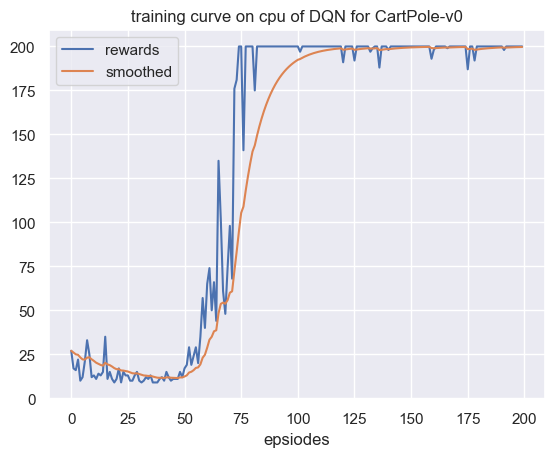

开始测试！
回合：1/20，奖励：200.00
回合：2/20，奖励：200.00
回合：3/20，奖励：200.00
回合：4/20，奖励：200.00
回合：5/20，奖励：200.00
回合：6/20，奖励：200.00
回合：7/20，奖励：200.00
回合：8/20，奖励：200.00
回合：9/20，奖励：200.00
回合：10/20，奖励：200.00
回合：11/20，奖励：200.00
回合：12/20，奖励：200.00
回合：13/20，奖励：200.00
回合：14/20，奖励：200.00
回合：15/20，奖励：200.00
回合：16/20，奖励：200.00
回合：17/20，奖励：200.00
回合：18/20，奖励：200.00
回合：19/20，奖励：200.00
回合：20/20，奖励：200.00
完成测试


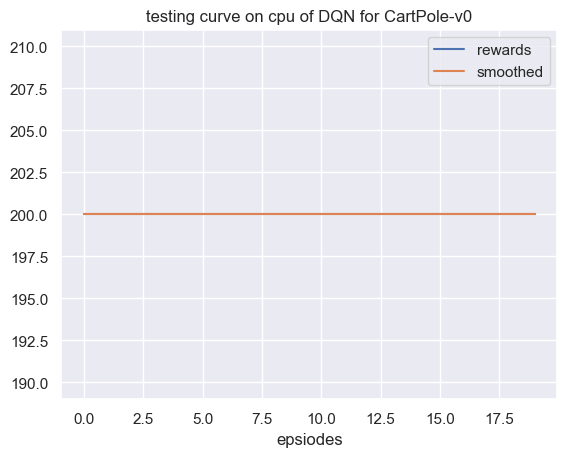

In [9]:
# 获取参数
cfg = get_args() 
# 训练
env, agent = env_agent_config(cfg)
res_dic = train(cfg, env, agent)
 
plot_rewards(res_dic['rewards'], cfg, tag="train")  
# 测试
res_dic = test(cfg, env, agent)
plot_rewards(res_dic['rewards'], cfg, tag="test")  # 画出结果